<a href="https://colab.research.google.com/github/leonSadowski/sc_Hierarchical_Classifier/blob/grid_search/NN_class_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#sc_Hierarchical_Classifier

#Needed Imports

In [1]:
import numpy as np 
import tensorflow as tf 
import tensorflow.keras as keras 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import networkx as nx
import random
from operator import add, sub

#Class Neural_Network 
Used Model for Local Classifiers of Hierarchical Classifier

In [10]:
import scvi

Global seed set to 0


In [ ]:
p_df = grid_search()

In [14]:
p_df = pd.read_csv('test.csv')

In [32]:
p_df

,index,test_accuracy,option_scVI,n_neurons,n_layers,dropout,learning_rate,momentum,batch_size,batch_norm,l2_reg,leakiness_ReLU
0,0,0.950573,20,128,2,0.2,0.005,0.9,40,False,False,0.1
1,1,0.940325,50,64,5,0.1,0.001,0.9,60,True,False,0.1
2,2,0.927667,50,64,10,0.2,0.005,0.5,40,False,False,0.1
3,3,0.926462,50,128,5,0.4,0.005,0.5,60,True,True,0.2
4,4,0.927667,50,256,10,0.1,0.005,0.9,20,False,True,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.934901,10,64,2,0.2,0.001,0.5,40,False,False,0.2
96,96,0.960217,10,256,5,0.4,0.001,0.9,40,False,False,0.2
97,97,0.913803,10,64,2,0.4,0.001,0.5,60,False,True,0.1
98,98,0.944545,20,256,10,0.1,0.005,0.5,20,False,False,0.1


In [12]:
def grid_search(
  adata_source = 'drive/MyDrive/TNK_Zhang_BRCA_labeled_Test.h5ad',
  options_scVI = [10, 20, 50],
  options_n_neurons = [64, 128, 256],
  options_n_layers = [2, 5, 10],
  options_dropout = [0.1, 0.2, 0.4],
  options_learning_rate = [0.001, 0.005],
  options_momentum = [0.5, 0.9],
  options_batch_size = [20, 40, 60],
  options_batch_norm = [True, False],
  options_l2_reg = [True, False],
  options_leakiness_ReLU = [0.1, 0.2],
  max_tries = 20,
  random_tries = 100,
):
  """
  Run on network initialization, i.e. upon creation of a hierarchical classifier
  and upon addition of a new node.
  Rationale for doing this on a per-node basis: factors such as network depth
  and number of neurons per hidden layer may be different with varying classification
  complexity.
  """
  adata = sc.read(adata_source)
  adata = adata[adata.obs['Level_4'] != ''].copy()
  for option_scVI in options_scVI:
    if f'X_scVI_{option_scVI}' in adata.obsm:
      continue
    
    scvi.model.SCVI.setup_anndata(adata, batch_key="batch")
    vae = scvi.model.SCVI(adata, n_latent=option_scVI)
    vae.train(max_epochs=100)
    adata.obsm[f'X_scVI_{option_scVI}'] = vae.get_latent_representation()
  
  adata.write(adata_source)
  performance_df = pd.DataFrame(columns=['test_accuracy', 'option_scVI', 'n_neurons', 'n_layers', 'dropout', 'learning_rate', 'momentum', 'batch_size', 'batch_norm', 'l2_reg', 'leakiness_ReLU'])
  for _ in range(random_tries):
    current_model = keras.models.Sequential()
    option_scVI = random.sample(options_scVI, 1) [0]
    n_neurons = random.sample(options_n_neurons, 1)[0]
    n_layers = random.sample(options_n_layers, 1)[0]
    dropout = random.sample(options_dropout, 1)[0]
    learning_rate = random.sample(options_learning_rate, 1)[0]
    momentum = random.sample(options_momentum, 1)[0]
    batch_size = random.sample(options_batch_size, 1)[0]
    batch_norm = random.sample(options_batch_norm, 1)[0]
    l2_reg = random.sample(options_l2_reg, 1)[0]
    leakiness_ReLU = random.sample(options_leakiness_ReLU, 1)[0]
    current_NN_helper = Neural_Network(
      adata.obsm[f'X_scVI_{option_scVI}'],
      adata.obs['Level_4'],
      5
    )



    neurons_per_layer = [len(current_NN_helper.x_input_data[0])]
    neurons_per_layer += n_layers * [n_neurons]
    neurons_per_layer += [current_NN_helper.len_of_output]
    for i, n_neurons_current in enumerate(neurons_per_layer):
      if i == len(neurons_per_layer) - 2:
        activation = 'softmax'
      
      elif i == len(neurons_per_layer) - 1:
        break

      else:
        activation = lambda x: keras.activations.relu(x, alpha=leakiness_ReLU)

      current_model.add(
          keras.layers.Dense(
              input_shape=(n_neurons_current, ),
              units=neurons_per_layer[i + 1],
              kernel_initializer='glorot_uniform',
              bias_initializer='zeros',
              activation=activation,
              activity_regularizer=keras.regularizers.l2(l2=0.01) if l2_reg == True else None
          )
      )

    current_optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    current_model.compile(optimizer=current_optimizer, loss=current_NN_helper.loss_function)
    history = current_model.fit(current_NN_helper.x_training_input, current_NN_helper.y_training_onehot,
                        batch_size = batch_size, epochs = current_NN_helper.epochs, 
                        verbose = 1,
                        validation_split = .1)


    current_NN_helper.y_training_preds = np.argmax(current_model.predict(current_NN_helper.x_training_input), axis = -1)
    current_NN_helper.y_test_preds = np.argmax(current_model.predict(current_NN_helper.x_test_input) , axis = -1)

    def calc_acc(pred_vec, known_vec):
      
      if type(pred_vec) == type(known_vec):
        acc = np.sum(pred_vec == known_vec, axis = 0) / len(known_vec)
      else:
        print('self.validate: Error! Comparison of different label encoding!')
      
      return acc

    train_acc = calc_acc(current_NN_helper.y_training_preds, current_NN_helper.y_training_input_int)
    test_acc = calc_acc(current_NN_helper.y_test_preds, current_NN_helper.y_test_input_int)

    parameters = {
      'test_accuracy': test_acc,
      'option_scVI': option_scVI,
      'n_neurons': n_neurons,
      'n_layers': n_layers,
      'dropout': dropout,
      'learning_rate': learning_rate,
      'momentum': momentum,
      'batch_size': batch_size,
      'batch_norm': batch_norm,
      'l2_reg': l2_reg, 
      'leakiness_ReLU': leakiness_ReLU
    }
    index = len(performance_df)
    for key, value in parameters.items():
      performance_df.loc[index, key] = value

    # Abort search if improvement in test accuracy has become insignificant
    if False: break

  return performance_df     

In [3]:
class Neural_Network():

  def __init__(self, 
               x_input_data,
               y_input_data,
               len_of_output, #NEU!!!!! ÜBERGEBE LÄNGE DES OUTPUT VEKTORS WEIL Y_INPUT für feinere Knoten KEIN PANDAS DATAFRAME MEHR IST
               z_transform_input = True,
               list_of_hidden_layer_nodes = [30],
               activation_function = 'relu',
               learning_rate = 0.001,
               momentum = .9,
               loss_function = 'categorical_crossentropy',
               epochs = 50):
    
    self.x_input_data = x_input_data
    self.y_input_data = y_input_data
    self.len_of_output = len_of_output
    self.list_of_layer_nodes = [len(self.x_input_data[0])] + [nodes for nodes in list_of_hidden_layer_nodes] + [len_of_output] #[len(self.y_input_data.cat.categories)] 
    self.activation_function = activation_function 
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.loss_function = loss_function
    self.epochs = epochs
    self.z_transform_input = z_transform_input

    #create model

    self.model = keras.models.Sequential()
    self.process_input_data()
    # Defer to grid_search to automatically find optimal hyperparameters for each nodes network
    # self.grid_search()
    for nodes, layer_idx in zip(self.list_of_layer_nodes, range(0, len(self.list_of_layer_nodes)-1)):

      self.model.add(keras.layers.Dense(
          input_shape = (nodes,),
          units = self.list_of_layer_nodes[layer_idx+1],                            
          kernel_initializer = 'glorot_uniform',                                          
          bias_initializer = 'zeros',                                               
          activation = self.activation_function if layer_idx == len(self.list_of_layer_nodes) - 1 else 'softmax'))

  def process_input_data(self):

    #z transformation 

    def z_transform_properties(data_arr):
      '''Calculates a z transformation to center properties across cells in data_arr around mean zero'''
      
      mean_vals = np.mean(data_arr, axis=0)
      std_val = np.std(data_arr)

      data_transformed = (data_arr - mean_vals) / std_val

      return data_transformed


    if self.z_transform_input:
      self.x_input_data = z_transform_properties(self.x_input_data)
      
    #converting labels of y_input_data to integers (mapping 'label'->int)

    # ----> erstmal so vereinfacht, dass incoming y_data encoded wird -> ist wegen group_by_labels eh mit strings

    print(f'network y_input before encoding: {self.y_input_data}')

    self.label_encoder = LabelEncoder()
    self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data)

    # if isinstance(self.y_input_data, pd.Series):
    #   #encode categorical labels from pandas Series as integers
    #   self.label_encoder = LabelEncoder()
    #   self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data.values)

    # elif isinstance(self.y_input_data[0], np.ndarray) and self.y_input_data.dtype == int: #so vereinfachen, dass einfach immer encoded wird. mit neuer 'pipeline' wird eh nur y_input mit strings weitergegeben
    #   self.y_input_data_int = self.y_input_data

    # elif isinstance(self.y_input_data[0], np.ndarray) and self.y_input_data.dtype == str: #y_input kein dataframe mehr, sondern Liste wegen preprocessing!
    #   self.y_input_data_int = self.label_encoder.fit_transform(self.y_input_data)

    # else:

    #   print('Error: Invalid or unknown Data Type for Y Input data')

  

    #split data (TO DO: implement scikit.learn cross_val_score for k-fold cross validation)

    split_data_index = int(2/3 * len(self.x_input_data))

    self.x_training_input = self.x_input_data[ : split_data_index]
    self.y_training_input_int = self.y_input_data_int[ : split_data_index]

    self.x_test_input = self.x_input_data[split_data_index : ]
    self.y_test_input_int = self.y_input_data_int[split_data_index : ]

    #use integer y_input data for OneHot Encoding (int -> e_i element R^(int+1)) needed for model training

    self.y_training_onehot = keras.utils.to_categorical(self.y_training_input_int)
    self.y_test_onehot = keras.utils.to_categorical(self.y_test_input_int)


  def train(self):
    '''Train the NN using the x_training_data input and onehot encoded y_training_onehot'''

    self.optimizer = keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum)
    
    self.model.compile(optimizer = self.optimizer, loss = self.loss_function)

    history = self.model.fit(self.x_training_input, self.y_training_onehot,
                        batch_size = 64, epochs = self.epochs, 
                        verbose = 1,
                        validation_split = .1)
    
  def predict(self, input_vec):
    '''Calculate and return label prediction of trained model for an input vector
        input_vec (dtype=int)'''

    #returns only absolute decisions, nothing known about the difference in prediction confidence 
    pred_vec = np.argmax(self.model.predict(input_vec), axis = -1) #-1?

    return pred_vec


  def validate(self):

    self.y_training_preds = self.predict(self.x_training_input)
    self.y_test_preds = self.predict(self.x_test_input) 

    def calc_acc(pred_vec, known_vec):
      
      if type(pred_vec) == type(known_vec):
        acc = np.sum(pred_vec == known_vec, axis = 0) / len(known_vec)
      else:
        print('self.validate: Error! Comparison of different label encoding!')
      
      return acc
    
    # ---> save in node memory, not in classifier model
    # self.train_acc = calc_acc(self.y_training_preds, self.y_training_input_int) 
    # self.test_acc = calc_acc(self.y_test_preds, self.y_test_input_int)

    train_acc = calc_acc(self.y_training_preds, self.y_training_input_int)
    test_acc = calc_acc(self.y_test_preds, self.y_test_input_int)

    return train_acc, test_acc


  def master_method_NN(self, validate):
    '''method to run all relevant neural network methods, to be called from hierarchical classifier!
    not sure if needed'''
    
    # self.process_input_data()
    # self.train()

    #prediction vector soll in node_memory gespeichert werden!

    pass

#Class Node_Memory
Save Data of local Classifier in Nodes of a directed Graph, initialized by Class Hierarchical_Classifier (see below)

In [ ]:
class Node_Memory():

  def __init__(self, x_input_data = None, y_input_data = None, local_classifier = None, local_classifier_params = []):

      #local_classifier argument is the Class of classifier (eg Neural_Network (classifier specific params, input and output needed for every possible classifier))
      #initialize all needed attributes, but assign via HC objects

      self.x_input_data = x_input_data  #processing wird von local classifier übernommen (CAVE bei Verwendung anderer LC (eg SVM), dass preprocessing einheitlich ist)
      self.y_input_data = y_input_data 

      self.y_input_grouped_labels = None  #is generated via Hierarchical classifier, maps all labels to labels of children of THIS node object

      self.apriori_y_input_data_indices = None #save indices of data in y_input vector, that will be used for prediction in order to compute accuracy
      
      #still manual splitting -> adjust to k fold CV in future
      self.training_prediction_vec = None
      self.test_prediction_vec = None

      self.training_acc = None
      self.test_acc = None

      #SEEEEEEEHR UNSCHÖÖÖÖÖÖN, PROBLEM MIT Y_INPUT_GROUPED_BY_LABELS_BEHEBEN!! DANN INITIALISIEREN WIEDER IN KONSTRUKTOR SCHREIBEN
      self.classifier_class = local_classifier #zwischenspeichern der Klasse bis y_input_grouped labels durch HC ausgegeben wurde --> SEHR UNSCHÖN
      self.local_classifier_params = local_classifier_params

  def initialize_local_classifier(self, local_classifier_output_len):
    print(f'zu übergebene y_input daten: {self.y_input_grouped_labels}')
    if self.classifier_class != None:
      self.local_classifier = self.classifier_class(self.x_input_data, self.y_input_grouped_labels, local_classifier_output_len, *self.local_classifier_params)  #use y_input with labels that refer to the child nodes
    else:
      #TO DO: bessere Lösung einfallen lassen
      print('WARNING! No classifier initialized!')

#Class Hierarchical_Classifier 
Initialize Directed Graph with Local Classifiers in Nodes

In [ ]:
def make_graph_from_edges(d, g, parent_key=''):
    for key in d.keys():
        if parent_key != '':
            g.add_edge(parent_key, key)
        if len(d[key]) == 0:
            pass
        else:
            make_graph_from_edges(d[key], g, parent_key=key)

In [ ]:
def list_subgraph_nodes(g, parent_node):
  list_of_nodes = []
  for node in g.adj[parent_node].keys():
    if len(g.adj[parent_node].keys()) != 0:
      list_of_nodes.append(node)
      list_of_nodes = list_of_nodes + list_subgraph_nodes(g, node)
    else:
      list_of_nodes.append(node)
  return list_of_nodes

In [ ]:
class Hierarchical_Classifier():
  '''Class connects Nodes of Local Classifiers, passes results to children classifiers and forms the final hierarchical classifier''' 

  def __init__(self, dict_of_cell_relations):
    '''Params
        - dict_of_cell_relations: used for initializing network structure of hierarchical classifier'''
    self.dict_of_cell_relations = dict_of_cell_relations


  def make_classifier_graph(self):
    '''Compute Graph from a given dictionary of cell relationships'''
    self.graph = nx.DiGraph()
    make_graph_from_edges(self.dict_of_cell_relations, self.graph)

  def init_node_memory_object(self, node, memory_class_params=[]):
    '''Add memory object to each node; memory object organizes all relevant local classifier params'''
    self.graph.add_node(node, memory=Node_Memory(*memory_class_params)) #lade die relevanten Daten
    if len(memory_class_params) != 0: #auch sehr unschön ---> so ändern, dass konflit mit NN Initialisierung und berechnen von y_input_grouped_labels in node memory nicht auftritt
      self.group_labels_of_subgraph_to_parent_label(node) #schreibe die relevanten (komprimierten) y_input daten durch aufrufen der methode
      
      print(f'Aus init_node_memory_object von Knoten {node}: output größe initialisiert als {len(self.graph.adj[node].keys())}')
      
      self.graph.nodes[node]['memory'].initialize_local_classifier(len(self.graph.adj[node].keys())) #initialisiere den local_classifier (jetzt ist y_input_grouped_labels wegen vorherigerm Methodenaufruf in node memory gegeben)
                                                                                                      #GEÄNDERT: ÜBERGEBE LÄNGE DES LETZTEN LAYERS DES NN, vorher aus cat.categories geschlossen
                                                                                                      #aber y_input_grouped_labels ist eine Liste
  def run_local_classifier(self, node):
    '''DEV METHOD: use for calling single methods at once to begin with'''
    
    #wo werden dem ersten local classifier die daten übergeben? --> aktuell manuell (s.u. TESTEN)

    #ONLY NEEDED FOR GLOBAL ACCURACY
    #save indices of known labels of daughter nodes in these corresponding nodes (i.e. eg node 'TNK' knows indices of 'TNK' in y_input_data of node 'all' ) 
    next_labels = [label for label in self.graph[node].keys()]
    for label in next_labels:
      self.graph.nodes[label]['memory'].apriori_y_input_data_indices = np.where(np.array(self.graph.nodes[node]['memory'].y_input_data) == label)

    #run needed local classifier methods to train model
    self.graph.nodes[node]['memory'].local_classifier.process_input_data()
    self.graph.nodes[node]['memory'].local_classifier.train()

    #predict trainings and test data (still splitted manually -> k fold cross validation) and save in corresponding node memory
    self.graph.nodes[node]['memory'].training_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.predict(self.graph.nodes[node]['memory'].local_classifier.x_training_input)
    self.graph.nodes[node]['memory'].test_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.predict(self.graph.nodes[node]['memory'].local_classifier.x_test_input)

    #validate model 
    self.graph.nodes[node]['memory'].training_acc, self.graph.nodes[node]['memory'].test_acc =  self.graph.nodes[node]['memory'].local_classifier.validate()


  def run_local_classifier_master(self, node, validate = True):
    '''run master method of local classifier'''
    pass


  #automatisches mapping der feineren labels zu den groberen durch iterieren über die Labels der subgraphen, ausführen über 
  #Hierarchical_Classifier in jedem Knoten --> als y_input_data in node_memory speichern
  #Ziel: mapping automatisieren, dafür: nimm 'Nachbarn' als nächste parentlabel, deren kinder müssen 
  #dann zu Nachbarn gemapped werden

  #benutze den graph, weil hier die ecken bereits klar sind, klarer als in gegebenem dictionary (dort müsste über keys von keys iteriert werden)

  def group_labels_of_subgraph_to_parent_label(self, super_node):
    '''Maps y_input_data labels to parent label (eg map (CD4 T, CD8 T, NK) -> (TNK) for all neighbors of given super_node (eg TNK, B, Others) of Graph g
      Params:
        - super_node: node at which local classifier has to be run
        
      Saves result in y_input_grouped_labels attribute of Node_memory of super_node''' 

    mapping_dict = {node : [child_node for child_node in list_subgraph_nodes(self.graph, node)] for node in self.graph.adj[super_node].keys() }

    #check if some neighbor nodes have already achieved highest annotation depth (terminal nodes) and map those to itself
    for key in mapping_dict.keys():
      if mapping_dict[key] == []:
        mapping_dict[key] = key

    mapper = {k:v for v,k in pd.Series(mapping_dict).explode().iteritems()} #write dict such that key and value are interchanged, then map; von StackOverFlow: letze antwort https://stackoverflow.com/questions/32262982/pandas-combining-multiple-categories-into-one
    

    #check if some cells were mislead and throw them out (otherwise they are labelled nan which gives more output units for neural network than needed + might be problematic for training of NN if 
    #cells are used asa data which were initially wrong, but are mapped to an output category)
    #DOES NOT WORK FOR PREDICTION OF UNLABELED CELLS OF COURSE! OPTION TRAINING/PREDICTION MODE NEEDED!

    idx_of_incorrectly_labelled_cells = []
    for cell_label, cell_idx in zip(self.graph.nodes[super_node]['memory'].y_input_data, range(0, len(self.graph.nodes[super_node]['memory'].y_input_data))):
      if cell_label not in mapper.keys():
        idx_of_incorrectly_labelled_cells.append(cell_idx)
    self.graph.nodes[super_node]['memory'].y_input_data = np.delete(self.graph.nodes[super_node]['memory'].y_input_data,idx_of_incorrectly_labelled_cells, axis = 0)
    self.graph.nodes[super_node]['memory'].x_input_data = np.delete(self.graph.nodes[super_node]['memory'].x_input_data,idx_of_incorrectly_labelled_cells, axis = 0)
    
    self.graph.nodes[super_node]['memory'].y_input_grouped_labels = [mapper.get(k) for k in self.graph.nodes[super_node]['memory'].y_input_data]
    

    

  def subset_pred_vec(self, node):
    next_labels = [label for label in self.graph[node].keys()]

    #fuse training and test data predictions to one prediction in order to have more data for next node (use local variable)
    current_pred_vec = np.concatenate((self.graph.nodes[node]['memory'].training_prediction_vec, self.graph.nodes[node]['memory'].test_prediction_vec), axis = 0)
    current_pred_vec = self.graph.nodes[node]['memory'].local_classifier.label_encoder.inverse_transform(current_pred_vec)

    for next_label in next_labels:

      #following line decodes integer output of neural network to string labels (for test and training data -> prediction vecs now overwritten, might be appropriate to use local variable) in order to compare with names of following nodes (again encoded by following local classifier)
      # self.graph.nodes[node]['memory'].training_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.label_encoder.inverse_transform(self.graph.nodes[node]['memory'].training_prediction_vec)
      # self.graph.nodes[node]['memory'].test_prediction_vec = self.graph.nodes[node]['memory'].local_classifier.label_encoder.inverse_transform(self.graph.nodes[node]['memory'].test_prediction_vec)
      # temp_idx_vec = np.where(np.array(self.graph.nodes[node]['memory'].prediction_vec) == next_label)
      
      #hier nochmal über auswirkung auf 'global accuracy' nachdenken -> falsch gelabelte zellen werden in group_labels_of_subgraph_to_parent_label
      #des entsprechenden classifiers/knoten herausgeworfen
      temp_idx_vec = np.where(current_pred_vec == next_label) 
      
      self.graph.nodes[next_label]['memory'].x_input_data = np.array(self.graph.nodes[node]['memory'].x_input_data)[temp_idx_vec]
      self.graph.nodes[next_label]['memory'].y_input_data = np.array(self.graph.nodes[node]['memory'].y_input_data)[temp_idx_vec]


  def master_method(self):
    '''method to run all relevant methods -> "one-click" initializing of hierarchical classifier (?)'''
    pass



#Test of Hierarchical Classifier 

In [4]:
!pip install scikit-misc

     |████████████████████████████████| 8.8 MB 9.0 MB/s 


In [5]:
!pip install scvi-tools

     |████████████████████████████████| 260 kB 22.1 MB/s 
     |████████████████████████████████| 224 kB 49.0 MB/s 
     |████████████████████████████████| 96 kB 5.0 MB/s 
     |████████████████████████████████| 713 kB 57.6 MB/s 
     |████████████████████████████████| 527 kB 52.4 MB/s 
     |████████████████████████████████| 136 kB 50.0 MB/s 
     |████████████████████████████████| 283 kB 52.2 MB/s 
     |████████████████████████████████| 397 kB 44.7 MB/s 
     |████████████████████████████████| 176 kB 53.3 MB/s 
     |████████████████████████████████| 134 kB 41.5 MB/s 
     |████████████████████████████████| 952 kB 41.8 MB/s 
     |████████████████████████████████| 596 kB 41.7 MB/s 
     |████████████████████████████████| 829 kB 43.3 MB/s 
     |████████████████████████████████| 1.1 MB 39.9 MB/s 
     |████████████████████████████████| 51 kB 3.5 MB/s 
     |████████████████████████████████| 97 kB 5.4 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████

In [6]:
!pip install scanpy 


     |████████████████████████████████| 2.0 MB 18.2 MB/s 
     |████████████████████████████████| 86 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 37.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=27f9b1a8ed4fda12eb8fc8927c25bd7b2c69f090dabfa99afb3e16a2c93781c9
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=a8585c271dd6fab2b41f7ba2afa582a4401b2ddac7233fc939b07b120d983131
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=e69dbbcf5fc13ff17272db2f4d316e5f812dd5ca917ea764abe70d6d1ed72889
  Stored in directory: /root/.cache/pip/wheels/68/ca/56/344d532fe53e855ccd6549795d370588ab812

In [7]:
import scanpy as sc

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
adata = sc.read('drive/MyDrive/TNK_Zhang_BRCA_labeled_Test.h5ad')
adata = adata[adata.obs['Level_4'] != '']
scvi.model.SCVI.setup_anndata(adata, batch_key="batch")
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=100)
adata.obsm['X_scvi'] = vae.get_latent_representation()
#adata = adata[adata.obs.sample(n=5000, replace=False, random_state=1, axis=0).index,:].copy()
#sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3', subset=True)

In [15]:
test_nn = Neural_Network(
    adata.obsm['X_scVI'],
    adata.obs['Level_4'],
    5)

network y_input before encoding: CATTATCCACAGCGTC.Post_P013_b    ab_T
ATCATGGCAAGGTGTG.Post_P023_b    ab_T
CGTGTAAAGACAGACC.Pre_P013_b     ab_T
TTGGAACCATCGATTG.Pre_P014_b       NK
AGCTCTCTCTCACATT.Post_P018_b    ab_T
                                ... 
AGAGTGGGTACGACCC.Prog_P013_b      NK
CAAGATCTCAACGGCC.Pre_P008_b     ab_T
GAGGTGAAGGCCCTCA.Pre_P014_b     ab_T
CCATGTCCAGCCACCA.Post_P017_b    ab_T
ATCGAGTTCATACGGT.Post_P002_b    ab_T
Name: Level_4, Length: 4975, dtype: category
Categories (5, object): ['ILC', 'MAIT', 'NK', 'ab_T', 'gd_T']


In [17]:
performance_df = test_nn.grid_search(random_tries=20)

Epoch 1/50
50/50 [==============================] - 2s 22ms/step - loss: 1.3175 - val_loss: 0.8488
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.7141 - val_loss: 0.5873
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5815 - val_loss: 0.5140
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.5205 - val_loss: 0.4686
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4787 - val_loss: 0.4348
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.4464 - val_loss: 0.4143
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.4207 - val_loss: 0.3887
Epoch 8/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3956 - val_loss: 0.3702
Epoch 9/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3768 - val_loss: 0.3486
Epoch 10/50
50/50 [==============================] - 0s 3ms/step - loss: 0.3582 - val_loss: 0.3528
Epoch 11/50
50/50 

In [19]:
performance_df

,test_accuracy,n_neurons,n_layers,dropout,learning_rate,momentum,batch_size,batch_norm,l2_reg,leakiness_ReLU
0,0.946956,64,5,0.1,0.005,0.9,60,False,True,0.2
1,0.94997,64,2,0.1,0.001,0.9,60,False,False,0.1
2,0.952984,256,2,0.1,0.001,0.9,20,False,True,0.2
3,0.918626,64,10,0.2,0.001,0.5,20,True,False,0.1
4,0.952381,64,2,0.2,0.001,0.9,60,False,False,0.2
5,0.952984,64,5,0.1,0.005,0.5,40,False,True,0.2
6,0.9566,128,5,0.2,0.005,0.5,20,True,False,0.2
7,0.952381,256,10,0.2,0.001,0.9,60,True,False,0.1
8,0.953586,64,2,0.4,0.005,0.5,20,False,True,0.1
9,0.951175,64,5,0.1,0.005,0.9,40,False,False,0.1


In [22]:
performance_df['test_accuracy'].astype(float)

0     0.946956
1     0.949970
2     0.952984
3     0.918626
4     0.952381
5     0.952984
6     0.956600
7     0.952381
8     0.953586
9     0.951175
10    0.952381
11    0.954792
12    0.945750
13    0.931284
14    0.949367
15    0.955998
16    0.951175
17    0.942737
18    0.953586
19    0.952381
Name: test_accuracy, dtype: float64

In [24]:
performance_df['test_accuracy'].astype(float).corr(performance_df['n_neurons'].astype(float))

0.13406756821673466

In [ ]:
import scvi

scvi.model.SCVI.setup_anndata(adata, batch_key="batch")
vae = scvi.model.SCVI(adata)
vae.train(max_epochs=100)
adata.obsm['X_scvi'] = vae.get_latent_representation()

Global seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 100/100: 100%|██████████| 100/100 [08:59<00:00,  5.40s/it, loss=764, v_num=1]


In [ ]:
adata.obsm['X_scVI'] = vae.get_latent_representation()
del adata.obsm['X_scvi']

In [ ]:
adata.obs['Level_3'].replace('ILC', 'ILC_ALL')

CATTATCCACAGCGTC.Post_P013_b          T
ATCATGGCAAGGTGTG.Post_P023_b          T
CGTGTAAAGACAGACC.Pre_P013_b           T
TTGGAACCATCGATTG.Pre_P014_b     ILC_ALL
AGCTCTCTCTCACATT.Post_P018_b          T
                                 ...   
AGAGTGGGTACGACCC.Prog_P013_b    ILC_ALL
CAAGATCTCAACGGCC.Pre_P008_b           T
GAGGTGAAGGCCCTCA.Pre_P014_b           T
CCATGTCCAGCCACCA.Post_P017_b          T
ATCGAGTTCATACGGT.Post_P002_b          T
Name: Level_3, Length: 5000, dtype: category
Categories (2, object): ['ILC_ALL', 'T']

In [ ]:
adata.write('drive/MyDrive/TNK_Zhang_BRCA_labeled_Test.h5ad')

In [ ]:
#adata = sc.read('drive/MyDrive/single_cell/processed/pbmc3k_level_1_scvi.h5ad')

In [ ]:
# adata.obs['leiden']

In [ ]:
# adata.obs['training_level_1']

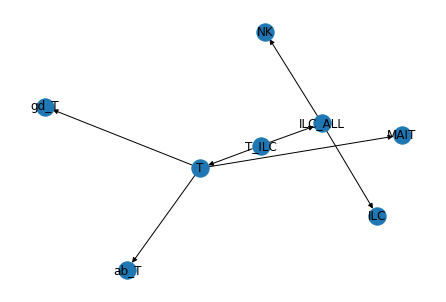

In [ ]:
#neues erstellen des digraphs, for loop setzt alle node memories zurück
#hc = Hierarchical_Classifier({'all': {'TNK':{'CD4 T':{}, 'CD8 T':{}, 'NK':{}}, 'Myeloisch':{'FCGR3A Monocytes': {}, 'Dendritic':{}, 'CD14 Monocytes':{}}, 'B': {}, 'Others':{'Megakaryocytes':{}}}})
hc = Hierarchical_Classifier(
  {
    'T_ILC': {
      'T': {
        'ab_T': {}, 
        'MAIT': {}, 
        'gd_T': {}
      }, 
      'ILC_ALL': {
        'NK': {},
        'ILC': {}
      } 
    }
  }
)
hc.make_classifier_graph()
for node in hc.graph.nodes:
  hc.init_node_memory_object(node)
nx.draw(hc.graph, with_labels=True)

In [ ]:
# list_subgraph_nodes(hc.graph, 'Myeloisch')

In [ ]:
# hc.group_labels_of_subgraph_to_parent_label('all')

In [ ]:
adata = adata[adata.obs['Level_4'] != '']

In [ ]:
#save input data and initialize first network in first node
hc.init_node_memory_object('T_ILC', [adata.obsm['X_scVI'], adata.obs['Level_4'], Neural_Network])

Aus init_node_memory_object von Knoten T_ILC: output größe initialisiert als 2
zu übergebene y_input daten: ['T', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', '

In [ ]:
#all set up - run local classifier
hc.run_local_classifier('T_ILC')

network y_input before encoding: ['T', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'ILC_ALL', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', 'T', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'ILC_ALL', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'ILC_ALL', 'T', 'T', 'T', 'T', 'T', 'ILC_ALL'

In [ ]:
#print first level classifier model accuracy
print(hc.graph.nodes['T_ILC']['memory'].training_acc)
print(hc.graph.nodes['T_ILC']['memory'].test_acc)

0.9731604342581424
0.9770946353224834


In [ ]:
hc.graph.nodes['T_ILC']['memory'].local_classifier.label_encoder.inverse_transform(hc.graph.nodes['T_ILC']['memory'].training_prediction_vec)

array(['T', 'T', 'T', ..., 'T', 'T', 'T'], dtype='<U7')

In [ ]:
#seperate output of first local classifier to local classifiers of child nodes
hc.subset_pred_vec('T_ILC')

In [ ]:
hc.graph.nodes['TNK']['memory'].__dict__

{'apriori_y_input_data_indices': (array([], dtype=int64),),
 'classifier_class': None,
 'local_classifier_params': [],
 'test_acc': None,
 'test_prediction_vec': None,
 'training_acc': None,
 'training_prediction_vec': None,
 'x_input_data': array([[-0.8241001 , -0.44704255, -0.4074863 , ...,  1.5713328 ,
         -1.546495  , -1.4017861 ],
        [-1.9270294 , -0.00890738,  0.97932434, ..., -0.6752965 ,
          0.28452635, -0.03110772],
        [-0.67081773, -0.9181075 , -0.8583566 , ...,  2.500195  ,
         -0.4206484 ,  1.1639605 ],
        ...,
        [-1.5681272 ,  1.3090951 ,  0.6303377 , ..., -1.2559723 ,
          0.4473528 ,  0.57438225],
        [ 0.01072386,  1.6088051 ,  1.7508733 , ..., -0.53124595,
          1.1915506 , -1.2604463 ],
        [-0.73548514, -0.02796707, -0.24904236, ...,  0.5823264 ,
         -0.28247118, -0.26726872]], dtype=float32),
 'y_input_data': array(['CD8 T', 'CD4 T', 'CD4 T', ..., 'CD4 T', 'B', 'CD4 T'],
       dtype=object),
 'y_input_group

In [ ]:
#zeigt input vektor bevor falsche zellen herausgeworfen wurden --> falsch zugeordnete Zellen zu sehen (hier Monozyten)
hc.graph.nodes['TNK']['memory'].y_input_data[0:100]

array(['CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD8 T', 'CD4 T',
       'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'NK', 'CD4 T', 'CD4 T', 'NK', 'CD8 T', 'CD4 T', 'NK', 'CD4 T',
       'CD8 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'NK', 'NK', 'NK', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'NK', 'CD4 T', 'NK', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD8 T',
       'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'NK',
       'CD4 T', 'CD8 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD8 T', 'CD8 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T', 'CD4 T', 'CD8 T', 'CD4 T',
       'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T', 'CD4 T'], dtype=object)

In [ ]:
#nun einmal alles für den tnk node 
#NN classifier initialisieren, hier noch unnötige Übergabe von input Daten, die er schon hat -> anders lösen, anderen Default, oder anderes initialisieren
hc.init_node_memory_object('T', [hc.graph.nodes['T']['memory'].x_input_data, hc.graph.nodes['T']['memory'].y_input_data, Neural_Network])

Aus init_node_memory_object von Knoten T: output größe initialisiert als 3
zu übergebene y_input daten: ['ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'gd_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'gd_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'MAIT', 'ab_T',

In [ ]:
hc.run_local_classifier('T')

network y_input before encoding: ['ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'gd_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'gd_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'ab_T', 'MAIT', 'ab_T', 'ab_T', 'ab_T', 'ab_T'

In [ ]:
#accuracy of tnk classifier model 
print(hc.graph.nodes['T']['memory'].training_acc)

print(hc.graph.nodes['T']['memory'].test_acc)

0.9499568593615185
0.9646246764452114


In [ ]:
#show saved prediction results in next labels, <- hm ne das wird erst später aufgerufen
hc.graph.nodes['ILC']['memory'].__dict__

{'apriori_y_input_data_indices': None,
 'classifier_class': __main__.Neural_Network,
 'local_classifier_params': [],
 'test_acc': None,
 'test_prediction_vec': None,
 'training_acc': None,
 'training_prediction_vec': None,
 'x_input_data': None,
 'y_input_data': None,
 'y_input_grouped_labels': None}

In [ ]:
#show status of node Myeloische Zellen
hc.graph.nodes['Myeloisch']['memory'].__dict__

{'apriori_y_input_data_indices': (array([], dtype=int64),),
 'classifier_class': None,
 'local_classifier_params': [],
 'test_acc': None,
 'test_prediction_vec': None,
 'training_acc': None,
 'training_prediction_vec': None,
 'x_input_data': array([[-0.65018964,  0.5909275 ,  0.17820597, ...,  0.7609098 ,
         -0.9427402 ,  1.1240003 ],
        [ 1.3202016 ,  0.6382091 , -1.6076678 , ..., -1.3887111 ,
         -0.43054047, -1.2502768 ],
        [ 0.03016484, -0.13684195,  0.38049364, ..., -0.8243723 ,
         -0.4725106 ,  0.7852393 ],
        ...,
        [ 0.00502422,  0.18570839,  0.38839135, ..., -0.05192301,
         -1.1637948 ,  1.4046977 ],
        [ 1.5008779 , -0.13873322, -0.09292659, ...,  0.1126502 ,
         -1.7490447 ,  1.5059206 ],
        [ 0.57691723, -0.09258436,  0.77182037, ..., -0.11639237,
          0.35169557,  1.8422029 ]], dtype=float32),
 'y_input_data': array(['NK', 'FCGR3A Monocytes', 'NK', 'CD14 Monocytes', 'CD14 Monocytes',
        'CD14 Monocytes',

In [ ]:
#initialisieren des local classifiers für den Myeloisch node
hc.init_node_memory_object('ILC_ALL', memory_class_params=[hc.graph.nodes['ILC_ALL']['memory'].x_input_data, hc.graph.nodes['ILC_ALL']['memory'].y_input_data, Neural_Network])

Aus init_node_memory_object von Knoten ILC_ALL: output größe initialisiert als 2
zu übergebene y_input daten: ['NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'ILC', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'ILC', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'ILC', 'NK', 'ILC', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK

In [ ]:
hc.run_local_classifier('ILC_ALL')

network y_input before encoding: ['NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'ILC', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'ILC', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'ILC', 'NK', 'ILC', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'NK', 'N

In [ ]:
#accuracy of myeloic classifier model 
print(hc.graph.nodes['ILC_ALL']['memory'].training_acc)

print(hc.graph.nodes['ILC_ALL']['memory'].test_acc)

0.9835886214442013
0.9846827133479212


Aktuell implementierte Objektauswahl macht Durchführung der Klassifizierung für 'Others' Knoten mit nur einem Tochterknoten sinnlos -> bräuchte direkte Ausgabe der softmax Aktivierungsfunktion um Wahrscheinlichkeiten auszugeben und dann eine confidence based entscheidung anstelle von auswahl des höchsten wertes (wäre dann immer eben der eine zur Wahl stehende Tochterknoten)

In [ ]:
#Neural_Netwok.model.summary() shows summary of hidden and output layers and trainable parameter